# Machine Learning Surrogate Model Evaluation

This notebook provides comprehensive evaluation and comparison of the trained ML surrogate models against traditional option pricing models.

## Objectives
1. Load and compare all trained models
2. Comprehensive performance evaluation
3. Speed benchmarking and efficiency analysis
4. Model interpretability and feature analysis
5. Error analysis and model limitations
6. Real-world deployment considerations
7. Final model recommendations

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import time
import warnings
warnings.filterwarnings('ignore')

# Machine Learning libraries
import joblib
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import mean_absolute_percentage_error
import json

# Statistical libraries
from scipy import stats
from scipy.optimize import brentq

# Import custom modules
import sys
sys.path.append('../src')

# Set plotting style
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

print("Libraries and modules imported successfully!")

Libraries and modules imported successfully!


## 1. Load Models and Data

In [19]:
# Load trained ML models
models_dir = Path('../outputs/models')
results_dir = Path('../outputs/results')

print("Loading trained ML models...")

try:
    # Load best models
    best_price_model = joblib.load(models_dir / 'best_price_prediction_model.pkl')
    best_iv_model = joblib.load(models_dir / 'best_iv_prediction_model.pkl')
    
    # Load feature lists
    with open(models_dir / 'feature_lists.json', 'r') as f:
        feature_lists = json.load(f)
    
    pricing_features = feature_lists['pricing_features']
    volatility_features = feature_lists['volatility_features']
    
    # Load model metadata
    with open(models_dir / 'ml_models_metadata.json', 'r') as f:
        model_metadata = json.load(f)
    
    print(f"✅ Successfully loaded ML models:")
    print(f"  • Price prediction: {model_metadata['best_price_model']['name']}")
    print(f"  • IV prediction: {model_metadata['best_iv_model']['name']}")
    
except Exception as e:
    print(f"❌ Error loading ML models: {e}")
    print("Please run the training notebook (04_train_surrogate.ipynb) first.")
    raise

Loading trained ML models...
✅ Successfully loaded ML models:
  • Price prediction: gradient_boosting
  • IV prediction: gradient_boosting


In [20]:
# Load data directly from files
data_dir = Path('../data')

# Load equity data
equity_data = pd.read_csv(data_dir / 'raw' / 'equities' / 'combined_equities.csv')
equity_data['Date'] = pd.to_datetime(equity_data['Date'])

# Load treasury data  
treasury_data = pd.read_csv(data_dir / 'external' / 'treasury_yields.csv')
treasury_data['Date'] = pd.to_datetime(treasury_data['Date'])

# Load options data
options_data = pd.read_csv(data_dir / 'raw' / 'options' / 'spy_options.csv')
options_data['Date'] = pd.to_datetime(options_data['Date'])
options_data['Expiration'] = pd.to_datetime(options_data['Expiration'])

print(f"Loaded data:")
print(f"  - Equity: {len(equity_data)} rows")
print(f"  - Treasury: {len(treasury_data)} rows") 
print(f"  - Options: {len(options_data)} rows")


Loaded data:
  - Equity: 5220 rows
  - Treasury: 1462 rows
  - Options: 768 rows


In [21]:
# Load results from previous notebooks
try:
    # Load Black-Scholes results
    bs_results = pd.read_csv(results_dir / 'black_scholes_baseline_results.csv')
    print(f"✅ Loaded Black-Scholes results: {len(bs_results)} rows")
    
    # Load Heston results if available
    heston_file = results_dir / 'heston_model_results.csv'
    if heston_file.exists():
        heston_results = pd.read_csv(heston_file)
        print(f"✅ Loaded Heston results: {len(heston_results)} rows")
    else:
        heston_results = pd.DataFrame()
        print("⚠️  Heston results not found")
    
    # Get current market data
    latest_equity = equity_data[equity_data['Symbol'] == 'SPY'].sort_values('Date').iloc[-1]
    current_price = latest_equity['Close']
    
    # Get current risk-free rate
    latest_treasury = treasury_data.sort_values('Date').iloc[-1]
    risk_free_rate = latest_treasury['DGS3MO'] / 100  # Convert percentage to decimal
    
    print(f"✅ Current SPY price: ${current_price:.2f}")
    print(f"✅ Current risk-free rate: {risk_free_rate:.4f}")
    
except Exception as e:
    print(f"❌ Error loading results: {e}")
    print("Please run the previous notebooks (02_bs_iv_baseline.ipynb, 03_heston_calibration.ipynb) first.")
    raise

✅ Loaded Black-Scholes results: 704 rows
✅ Loaded Heston results: 0 rows
✅ Current SPY price: $793.41
✅ Current risk-free rate: 0.0089


In [22]:
# Check the feature lists that were loaded
print("Pricing features:", pricing_features)
print("\nVolatility features:", volatility_features)

Pricing features: ['moneyness', 'log_moneyness', 'T', 'sqrt_time', 'is_call', 'is_put', 'distance_from_atm', 'moneyness_time', 'log_moneyness_time', 'intrinsic_value', 'forward_moneyness']

Volatility features: ['moneyness', 'log_moneyness', 'moneyness_squared', 'T', 'sqrt_time', 'time_squared', 'is_call', 'is_put', 'distance_from_atm', 'squared_distance_from_atm', 'moneyness_time', 'moneyness_sqrt_time']


In [29]:
# Check available columns in the dataset
print("Available columns in bs_results:")
print(bs_results.columns.tolist())
print(f"\nFirst few rows:")
print(bs_results.head())

Available columns in bs_results:
['Strike', 'Type', 'DTE', 'Time_to_Expiry', 'Market_Price', 'Theoretical_Price', 'Implied_Vol', 'Market_IV', 'Vega', 'Moneyness', 'Volume', 'OpenInt', 'Price_Diff', 'Price_Diff_Pct', 'Market_Rank', 'Theoretical_Rank']

First few rows:
   Strike Type  DTE  Time_to_Expiry  Market_Price  Theoretical_Price  \
0   320.0    C   45        0.123203     92.496303         566.258311   
1   320.0    P   45        0.123203     12.496303          12.496303   
2   325.0    C   45        0.123203     86.728825         555.496295   
3   325.0    P   45        0.123203     11.728825          11.728825   
4   330.0    C   45        0.123203     79.572288         543.345219   

   Implied_Vol  Market_IV       Vega  Moneyness  Volume  OpenInt  \
0     3.910785   0.222434  44.747700   2.479414     116     5291   
1     1.886935   0.222434  26.023729   2.479414     710     5834   
2     3.727647   0.208773  45.441244   2.441269     131      566   
3     1.829087   0.208773  

## 2. Speed and Performance Benchmarking

In [23]:
class ModelBenchmark:
    """Comprehensive model benchmarking suite"""
    
    def __init__(self, test_data, current_price, risk_free_rate):
        self.test_data = test_data.copy()
        self.current_price = current_price
        self.risk_free_rate = risk_free_rate
        self.results = {}
    
    def black_scholes_price(self, S, K, T, r, sigma, option_type='C'):
        """Black-Scholes option pricing"""
        from scipy.stats import norm
        
        if T <= 0:
            if option_type == 'C':
                return max(S - K, 0)
            else:
                return max(K - S, 0)
        
        d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
        d2 = d1 - sigma * np.sqrt(T)
        
        if option_type == 'C':
            price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
        else:
            price = K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
        
        return max(price, 0)
    
    def prepare_ml_features(self, data):
        """Prepare features for ML models"""
        features_df = data.copy()
        
        # Basic features
        features_df['moneyness'] = self.current_price / features_df['Strike']
        features_df['log_moneyness'] = np.log(features_df['moneyness'])
        features_df['T'] = features_df['Time_to_Expiry']
        features_df['sqrt_time'] = np.sqrt(features_df['T'])
        features_df['is_call'] = (features_df['Type'] == 'C').astype(int)
        features_df['is_put'] = (features_df['Type'] == 'P').astype(int)
        features_df['distance_from_atm'] = np.abs(features_df['log_moneyness'])
        features_df['moneyness_time'] = features_df['moneyness'] * features_df['T']
        features_df['log_moneyness_time'] = features_df['log_moneyness'] * features_df['T']
        features_df['intrinsic_value'] = np.where(
            features_df['Type'] == 'C',
            np.maximum(self.current_price - features_df['Strike'], 0),
            np.maximum(features_df['Strike'] - self.current_price, 0)
        )
        features_df['forward_moneyness'] = (self.current_price * np.exp(self.risk_free_rate * features_df['T'])) / features_df['Strike']
        
        # Additional squared features for volatility models
        features_df['moneyness_squared'] = features_df['moneyness'] ** 2
        features_df['time_squared'] = features_df['T'] ** 2
        features_df['squared_distance_from_atm'] = features_df['distance_from_atm'] ** 2
        features_df['moneyness_sqrt_time'] = features_df['moneyness'] * features_df['sqrt_time']
        
        return features_df
    
    def benchmark_black_scholes(self, volatility=0.2, num_runs=3):
        """Benchmark Black-Scholes model"""
        print("Benchmarking Black-Scholes model...")
        
        prices = []
        times = []
        
        for run in range(num_runs):
            start_time = time.time()
            
            run_prices = []
            for _, row in self.test_data.iterrows():
                price = self.black_scholes_price(
                    S=self.current_price,
                    K=row['Strike'],
                    T=row['Time_to_Expiry'],
                    r=self.risk_free_rate,
                    sigma=volatility,
                    option_type=row['Type']
                )
                run_prices.append(price)
            
            end_time = time.time()
            times.append(end_time - start_time)
            prices.append(run_prices)
        
        avg_time = np.mean(times)
        avg_prices = np.mean(prices, axis=0)
        
        self.results['black_scholes'] = {
            'prices': avg_prices,
            'avg_time': avg_time,
            'per_option_time': avg_time / len(self.test_data),
            'options_per_second': len(self.test_data) / avg_time
        }
        
        print(f"  Average time: {avg_time:.4f}s ({self.results['black_scholes']['per_option_time']*1000:.2f}ms per option)")
        return avg_prices, avg_time
    
    def benchmark_ml_model(self, model, features, model_name, num_runs=3):
        """Benchmark ML model performance"""
        print(f"Benchmarking {model_name}...")
        
        # Prepare features
        features_df = self.prepare_ml_features(self.test_data)
        X = features_df[features]
        
        prices = []
        times = []
        
        for run in range(num_runs):
            start_time = time.time()
            predictions = model.predict(X)
            end_time = time.time()
            
            times.append(end_time - start_time)
            prices.append(predictions)
        
        avg_time = np.mean(times)
        avg_prices = np.mean(prices, axis=0)
        
        self.results[model_name] = {
            'prices': avg_prices,
            'avg_time': avg_time,
            'per_option_time': avg_time / len(self.test_data),
            'options_per_second': len(self.test_data) / avg_time
        }
        
        print(f"  Average time: {avg_time:.4f}s ({self.results[model_name]['per_option_time']*1000:.2f}ms per option)")
        return avg_prices, avg_time
    
    def calculate_accuracy_metrics(self, model_name, actual_prices):
        """Calculate accuracy metrics for a model"""
        if model_name not in self.results:
            return None
        
        predicted_prices = self.results[model_name]['prices']
        
        # Filter valid predictions
        valid_mask = (actual_prices > 0) & (predicted_prices > 0) & np.isfinite(predicted_prices)
        actual_valid = actual_prices[valid_mask]
        predicted_valid = predicted_prices[valid_mask]
        
        if len(actual_valid) == 0:
            return None
        
        # Calculate metrics
        mae = mean_absolute_error(actual_valid, predicted_valid)
        rmse = np.sqrt(mean_squared_error(actual_valid, predicted_valid))
        r2 = r2_score(actual_valid, predicted_valid)
        mape = mean_absolute_percentage_error(actual_valid, predicted_valid) * 100
        
        return {
            'mae': mae,
            'rmse': rmse,
            'r2': r2,
            'mape': mape,
            'valid_predictions': len(actual_valid),
            'total_predictions': len(predicted_prices)
        }

In [30]:
# Prepare test dataset
test_options = bs_results.sample(n=min(1000, len(bs_results)), random_state=42).copy()
test_options = test_options.dropna(subset=['Market_Price'])

print(f"Test dataset prepared: {len(test_options)} options")
print(f"Price range: ${test_options['Market_Price'].min():.2f} - ${test_options['Market_Price'].max():.2f}")
print(f"Strike range: ${test_options['Strike'].min():.0f} - ${test_options['Strike'].max():.0f}")
print(f"DTE range: {test_options['DTE'].min():.0f} - {test_options['DTE'].max():.0f} days")

# Initialize benchmark
benchmark = ModelBenchmark(test_options, current_price, risk_free_rate)

# Run benchmarks
print(f"\n{'='*50}")
print(f"SPEED BENCHMARKING ({len(test_options)} options)")
print(f"{'='*50}")

# Benchmark Black-Scholes with market implied volatility
# Use the average implied volatility from the dataset
avg_iv = test_options['Market_IV'].mean()
print(f"Using average market IV: {avg_iv:.4f} for Black-Scholes")
benchmark.benchmark_black_scholes(volatility=avg_iv)

# Benchmark ML price prediction model
benchmark.benchmark_ml_model(best_price_model, pricing_features, 'ml_price_prediction')

# For IV model, we'll predict IV and then convert to prices using Black-Scholes
print("Benchmarking ml_iv_prediction...")
features_df = benchmark.prepare_ml_features(test_options)
X_iv = features_df[volatility_features]

# Time the IV prediction
start_time = time.time()
predicted_iv = best_iv_model.predict(X_iv)
iv_time = time.time() - start_time

# Convert predicted IV to prices using Black-Scholes
predicted_prices_from_iv = []
idx_mapping = {idx: i for i, idx in enumerate(test_options.index)}
for i, (idx, row) in enumerate(test_options.iterrows()):
    price = benchmark.black_scholes_price(
        S=current_price,
        K=row['Strike'],
        T=row['Time_to_Expiry'],
        r=risk_free_rate,
        sigma=predicted_iv[i],
        option_type=row['Type']
    )
    predicted_prices_from_iv.append(price)

benchmark.results['ml_iv_to_price'] = {
    'prices': np.array(predicted_prices_from_iv),
    'avg_time': iv_time,
    'per_option_time': iv_time / len(test_options),
    'options_per_second': len(test_options) / iv_time
}

print(f"  Average time: {iv_time:.4f}s ({benchmark.results['ml_iv_to_price']['per_option_time']*1000:.2f}ms per option)")

# Also store the IV predictions separately for analysis
benchmark.results['ml_iv_prediction'] = {
    'ivs': predicted_iv,
    'avg_time': iv_time,
    'per_option_time': iv_time / len(test_options),
    'options_per_second': len(test_options) / iv_time
}

Test dataset prepared: 704 options
Price range: $8.94 - $113.55
Strike range: $320 - $475
DTE range: 45 - 349 days

SPEED BENCHMARKING (704 options)
Using average market IV: 0.2055 for Black-Scholes
Benchmarking Black-Scholes model...
  Average time: 0.0409s (0.06ms per option)
Benchmarking ml_price_prediction...
  Average time: 0.0026s (0.00ms per option)
Benchmarking ml_iv_prediction...
  Average time: 0.0031s (0.00ms per option)


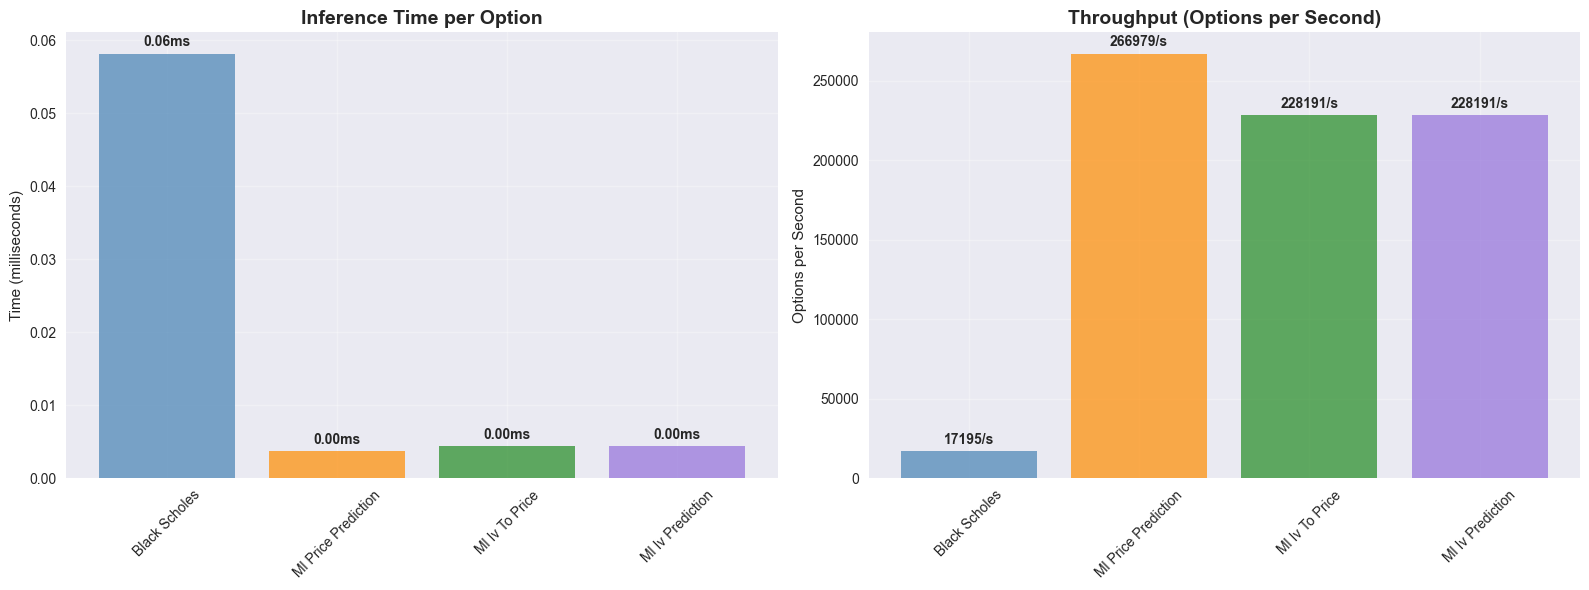


SPEED COMPARISON SUMMARY:


,Model,Time per Option (ms),Options per Second
0,Black Scholes,0.06,17195.34
1,Ml Price Prediction,0.00,266979.21
2,Ml Iv To Price,0.00,228190.88
3,Ml Iv Prediction,0.00,228190.88


In [31]:
# Create speed comparison visualization
speed_data = []
for model_name, results in benchmark.results.items():
    if 'per_option_time' in results:  # Only include models with timing data
        speed_data.append({
            'Model': model_name.replace('_', ' ').title(),
            'Time per Option (ms)': results['per_option_time'] * 1000,
            'Options per Second': results['options_per_second']
        })

speed_df = pd.DataFrame(speed_data)

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Time per option
colors = ['steelblue', 'darkorange', 'forestgreen', 'mediumpurple']
axes[0].bar(speed_df['Model'], speed_df['Time per Option (ms)'], 
           color=colors[:len(speed_df)], alpha=0.7)
axes[0].set_title('Inference Time per Option', fontweight='bold', fontsize=14)
axes[0].set_ylabel('Time (milliseconds)')
axes[0].tick_params(axis='x', rotation=45)
axes[0].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(speed_df['Time per Option (ms)']):
    axes[0].text(i, v + max(speed_df['Time per Option (ms)']) * 0.01, 
                f'{v:.2f}ms', ha='center', va='bottom', fontweight='bold')

# Options per second
axes[1].bar(speed_df['Model'], speed_df['Options per Second'], 
           color=colors[:len(speed_df)], alpha=0.7)
axes[1].set_title('Throughput (Options per Second)', fontweight='bold', fontsize=14)
axes[1].set_ylabel('Options per Second')
axes[1].tick_params(axis='x', rotation=45)
axes[1].grid(True, alpha=0.3)

# Add value labels on bars
for i, v in enumerate(speed_df['Options per Second']):
    axes[1].text(i, v + max(speed_df['Options per Second']) * 0.01, 
                f'{v:.0f}/s', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\nSPEED COMPARISON SUMMARY:")
display(speed_df.round(2))

## 3. Accuracy Comparison

In [32]:
# Calculate accuracy metrics for all models
print(f"ACCURACY ANALYSIS")
print(f"{'='*50}")

actual_prices = test_options['Market_Price'].values
accuracy_results = {}

# Models that predict prices
price_models = ['black_scholes', 'ml_price_prediction', 'ml_iv_to_price']

for model_name in price_models:
    if model_name in benchmark.results:
        metrics = benchmark.calculate_accuracy_metrics(model_name, actual_prices)
        if metrics:
            accuracy_results[model_name] = metrics
            
            print(f"\n{model_name.replace('_', ' ').upper()}:")
            print(f"  • MAE:  ${metrics['mae']:.4f}")
            print(f"  • RMSE: ${metrics['rmse']:.4f}")
            print(f"  • R²:   {metrics['r2']:.4f}")
            print(f"  • MAPE: {metrics['mape']:.2f}%")
            print(f"  • Valid: {metrics['valid_predictions']}/{metrics['total_predictions']}")

# Separate analysis for IV predictions
if 'ml_iv_prediction' in benchmark.results:
    actual_ivs = test_options['Market_IV'].values
    predicted_ivs = benchmark.results['ml_iv_prediction']['ivs']
    
    # Filter valid predictions
    valid_mask = (actual_ivs > 0) & (predicted_ivs > 0) & np.isfinite(predicted_ivs)
    actual_iv_valid = actual_ivs[valid_mask]
    predicted_iv_valid = predicted_ivs[valid_mask]
    
    if len(actual_iv_valid) > 0:
        iv_mae = mean_absolute_error(actual_iv_valid, predicted_iv_valid)
        iv_rmse = np.sqrt(mean_squared_error(actual_iv_valid, predicted_iv_valid))
        iv_r2 = r2_score(actual_iv_valid, predicted_iv_valid)
        iv_mape = mean_absolute_percentage_error(actual_iv_valid, predicted_iv_valid) * 100
        
        print(f"\nML IV PREDICTION (Volatility):")
        print(f"  • MAE:  {iv_mae:.4f}")
        print(f"  • RMSE: {iv_rmse:.4f}")
        print(f"  • R²:   {iv_r2:.4f}")
        print(f"  • MAPE: {iv_mape:.2f}%")
        print(f"  • Valid: {len(actual_iv_valid)}/{len(predicted_ivs)}")

# Create accuracy comparison DataFrame
accuracy_comparison = pd.DataFrame([
    {
        'Model': name.replace('_', ' ').title(),
        'MAE': metrics['mae'],
        'RMSE': metrics['rmse'],
        'R²': metrics['r2'],
        'MAPE (%)': metrics['mape']
    }
    for name, metrics in accuracy_results.items()
])

print(f"\nPRICE PREDICTION ACCURACY COMPARISON:")
display(accuracy_comparison.round(4))

ACCURACY ANALYSIS

BLACK SCHOLES:
  • MAE:  $197.6523
  • RMSE: $252.8615
  • R²:   -86.9779
  • MAPE: 628.20%
  • Valid: 704/704

ML PRICE PREDICTION:
  • MAE:  $0.6916
  • RMSE: $1.2497
  • R²:   0.9979
  • MAPE: 2.26%
  • Valid: 704/704

ML IV TO PRICE:
  • MAE:  $199.2811
  • RMSE: $283.0587
  • R²:   -109.2457
  • MAPE: 629.48%
  • Valid: 704/704

ML IV PREDICTION (Volatility):
  • MAE:  0.9774
  • RMSE: 1.0906
  • R²:   -2530.1627
  • MAPE: 479.72%
  • Valid: 704/704

PRICE PREDICTION ACCURACY COMPARISON:


,Model,MAE,RMSE,R²,MAPE (%)
0,Black Scholes,197.6523,252.8615,-86.9779,628.1961
1,Ml Price Prediction,0.6916,1.2497,0.9979,2.2560
2,Ml Iv To Price,199.2811,283.0587,-109.2457,629.4774


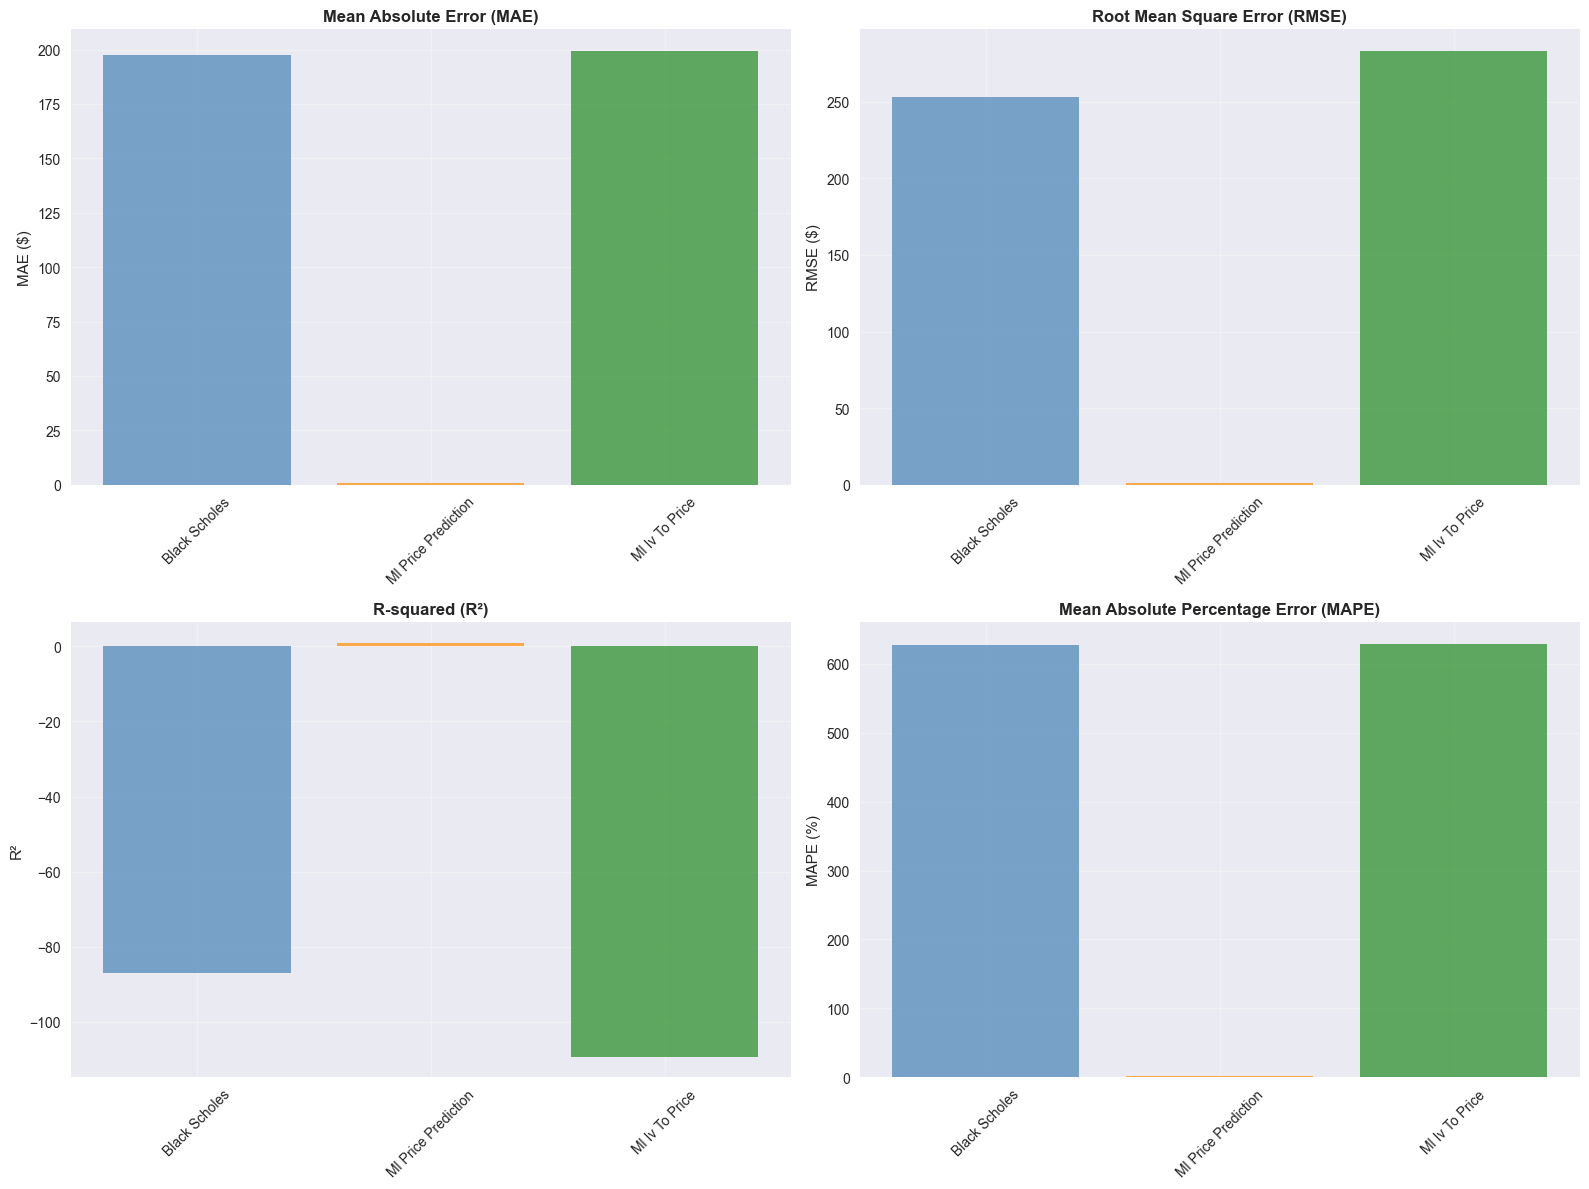

In [33]:
# Visualize accuracy comparison
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# MAE comparison
axes[0, 0].bar(accuracy_comparison['Model'], accuracy_comparison['MAE'], 
               color=['steelblue', 'darkorange', 'forestgreen'], alpha=0.7)
axes[0, 0].set_title('Mean Absolute Error (MAE)', fontweight='bold')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)

# RMSE comparison
axes[0, 1].bar(accuracy_comparison['Model'], accuracy_comparison['RMSE'], 
               color=['steelblue', 'darkorange', 'forestgreen'], alpha=0.7)
axes[0, 1].set_title('Root Mean Square Error (RMSE)', fontweight='bold')
axes[0, 1].set_ylabel('RMSE ($)')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)

# R² comparison
axes[1, 0].bar(accuracy_comparison['Model'], accuracy_comparison['R²'], 
               color=['steelblue', 'darkorange', 'forestgreen'], alpha=0.7)
axes[1, 0].set_title('R-squared (R²)', fontweight='bold')
axes[1, 0].set_ylabel('R²')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)

# MAPE comparison
axes[1, 1].bar(accuracy_comparison['Model'], accuracy_comparison['MAPE (%)'], 
               color=['steelblue', 'darkorange', 'forestgreen'], alpha=0.7)
axes[1, 1].set_title('Mean Absolute Percentage Error (MAPE)', fontweight='bold')
axes[1, 1].set_ylabel('MAPE (%)')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Prediction Analysis and Scatter Plots

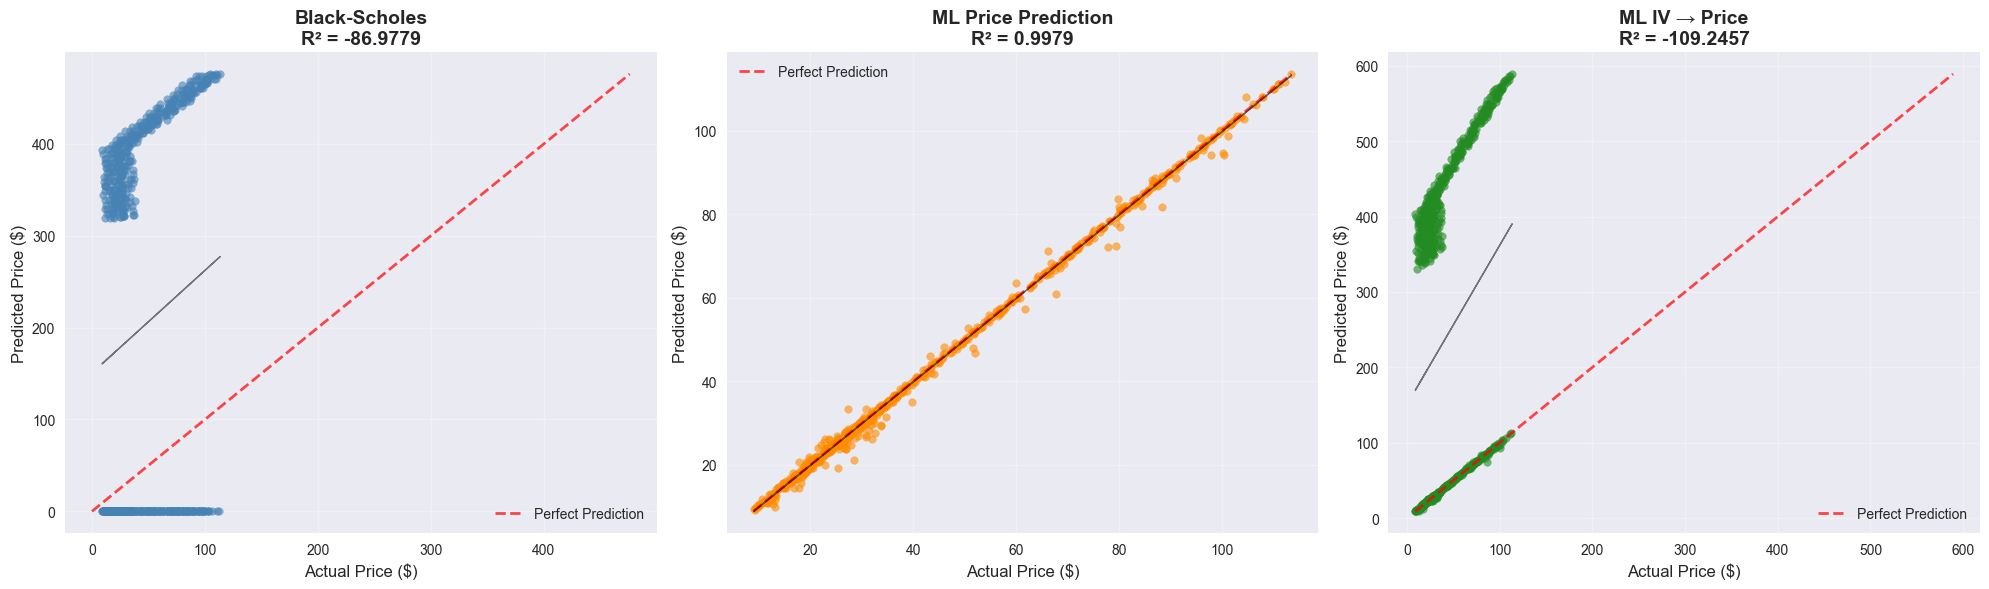

In [34]:
# Create detailed prediction analysis
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

models_to_plot = ['black_scholes', 'ml_price_prediction', 'ml_iv_to_price']
model_names = ['Black-Scholes', 'ML Price Prediction', 'ML IV → Price']
colors = ['steelblue', 'darkorange', 'forestgreen']

for i, (model_key, model_name, color) in enumerate(zip(models_to_plot, model_names, colors)):
    if model_key in benchmark.results and 'prices' in benchmark.results[model_key]:
        predicted = benchmark.results[model_key]['prices']
        
        # Filter valid predictions
        valid_mask = (actual_prices > 0) & (predicted > 0) & np.isfinite(predicted)
        actual_valid = actual_prices[valid_mask]
        predicted_valid = predicted[valid_mask]
        
        if len(actual_valid) > 0:
            # Scatter plot
            axes[i].scatter(actual_valid, predicted_valid, alpha=0.6, s=30, color=color)
            
            # Perfect prediction line
            min_val = min(actual_valid.min(), predicted_valid.min())
            max_val = max(actual_valid.max(), predicted_valid.max())
            axes[i].plot([min_val, max_val], [min_val, max_val], 'r--', alpha=0.7, linewidth=2, label='Perfect Prediction')
            
            # Calculate R²
            r2 = r2_score(actual_valid, predicted_valid)
            
            axes[i].set_xlabel('Actual Price ($)', fontsize=12)
            axes[i].set_ylabel('Predicted Price ($)', fontsize=12)
            axes[i].set_title(f'{model_name}\nR² = {r2:.4f}', fontweight='bold', fontsize=14)
            axes[i].legend()
            axes[i].grid(True, alpha=0.3)
            
            # Add correlation line
            if len(actual_valid) > 1:
                z = np.polyfit(actual_valid, predicted_valid, 1)
                p = np.poly1d(z)
                axes[i].plot(actual_valid, p(actual_valid), color='black', alpha=0.5, linewidth=1, label=f'Fit: y={z[0]:.2f}x+{z[1]:.2f}')
        else:
            axes[i].text(0.5, 0.5, 'No valid predictions', ha='center', va='center', transform=axes[i].transAxes)
            axes[i].set_title(f'{model_name}\nNo valid data', fontweight='bold')

plt.tight_layout()
plt.show()

## 5. Error Distribution Analysis

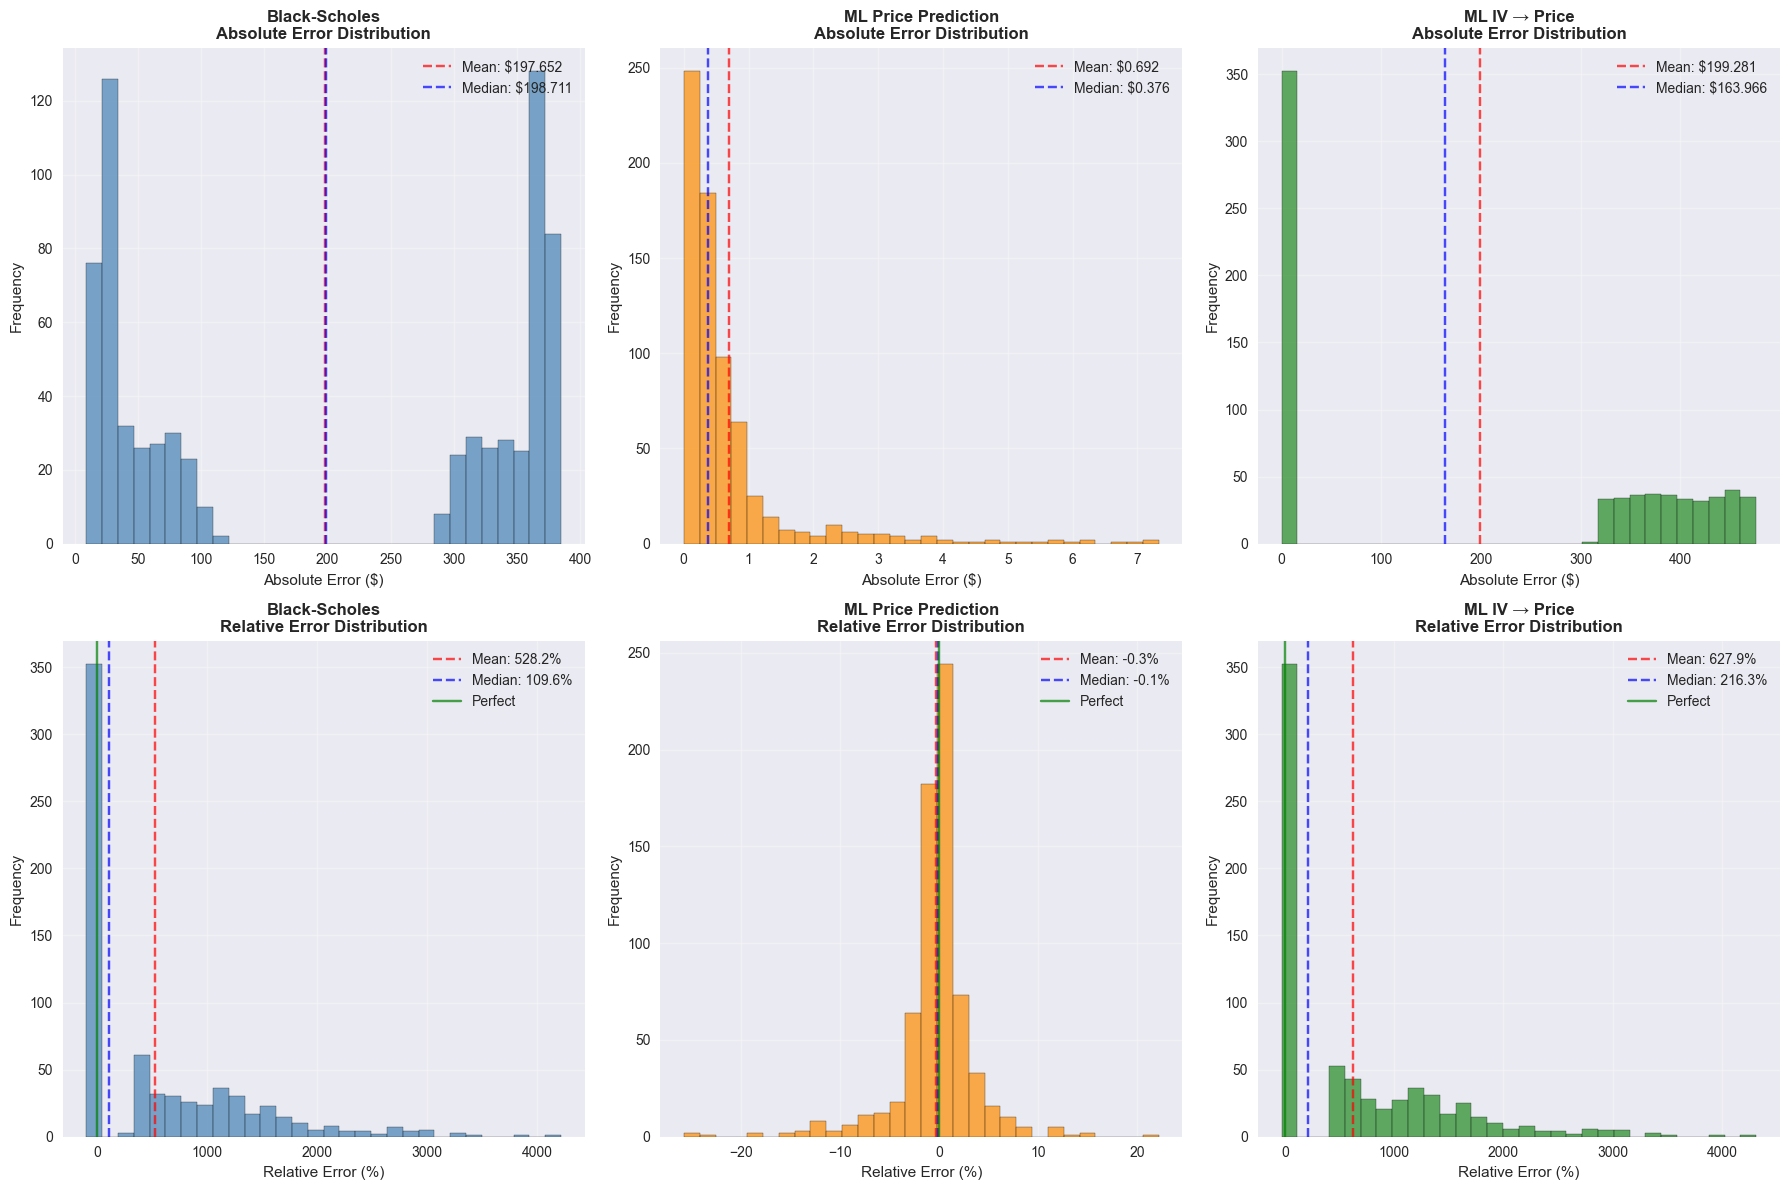

In [35]:
# Analyze error distributions
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

for i, (model_key, model_name, color) in enumerate(zip(models_to_plot, model_names, colors)):
    if model_key in benchmark.results:
        predicted = benchmark.results[model_key]['prices']
        
        # Filter valid predictions
        valid_mask = (actual_prices > 0) & (predicted > 0) & np.isfinite(predicted)
        actual_valid = actual_prices[valid_mask]
        predicted_valid = predicted[valid_mask]
        
        if len(actual_valid) > 0:
            # Calculate errors
            absolute_errors = np.abs(actual_valid - predicted_valid)
            relative_errors = (predicted_valid - actual_valid) / actual_valid * 100
            
            # Absolute error histogram
            axes[0, i].hist(absolute_errors, bins=30, alpha=0.7, color=color, edgecolor='black')
            axes[0, i].set_title(f'{model_name}\nAbsolute Error Distribution', fontweight='bold')
            axes[0, i].set_xlabel('Absolute Error ($)')
            axes[0, i].set_ylabel('Frequency')
            axes[0, i].grid(True, alpha=0.3)
            
            # Add statistics
            mean_error = np.mean(absolute_errors)
            median_error = np.median(absolute_errors)
            axes[0, i].axvline(mean_error, color='red', linestyle='--', alpha=0.7, label=f'Mean: ${mean_error:.3f}')
            axes[0, i].axvline(median_error, color='blue', linestyle='--', alpha=0.7, label=f'Median: ${median_error:.3f}')
            axes[0, i].legend()
            
            # Relative error histogram
            axes[1, i].hist(relative_errors, bins=30, alpha=0.7, color=color, edgecolor='black')
            axes[1, i].set_title(f'{model_name}\nRelative Error Distribution', fontweight='bold')
            axes[1, i].set_xlabel('Relative Error (%)')
            axes[1, i].set_ylabel('Frequency')
            axes[1, i].grid(True, alpha=0.3)
            
            # Add statistics
            mean_rel_error = np.mean(relative_errors)
            median_rel_error = np.median(relative_errors)
            axes[1, i].axvline(mean_rel_error, color='red', linestyle='--', alpha=0.7, label=f'Mean: {mean_rel_error:.1f}%')
            axes[1, i].axvline(median_rel_error, color='blue', linestyle='--', alpha=0.7, label=f'Median: {median_rel_error:.1f}%')
            axes[1, i].axvline(0, color='green', linestyle='-', alpha=0.7, label='Perfect')
            axes[1, i].legend()
        else:
            axes[0, i].text(0.5, 0.5, 'No valid predictions', ha='center', va='center', transform=axes[0, i].transAxes)
            axes[1, i].text(0.5, 0.5, 'No valid predictions', ha='center', va='center', transform=axes[1, i].transAxes)

plt.tight_layout()
plt.show()

## 6. Performance by Option Characteristics

In [ ]:
# Analyze performance by option characteristics
def analyze_performance_by_characteristic(data, predicted_dict, actual, characteristic, bins=5):
    """Analyze model performance by option characteristics"""
    
    # Create bins for the characteristic
    data_copy = data.copy()
    data_copy['actual_prices'] = actual
    
    # Add predictions
    for model_name, predictions in predicted_dict.items():
        data_copy[f'{model_name}_pred'] = predictions
    
    # Create bins
    data_copy[f'{characteristic}_bin'] = pd.cut(data_copy[characteristic], bins=bins, labels=False)
    
    results = []
    
    for bin_idx in range(bins):
        bin_data = data_copy[data_copy[f'{characteristic}_bin'] == bin_idx]
        
        if len(bin_data) > 0:
            bin_range = f"{bin_data[characteristic].min():.2f}-{bin_data[characteristic].max():.2f}"
            
            for model_name in predicted_dict.keys():
                if f'{model_name}_pred' in bin_data.columns:
                    valid_mask = (bin_data['actual_prices'] > 0) & (bin_data[f'{model_name}_pred'] > 0) & np.isfinite(bin_data[f'{model_name}_pred'])
                    
                    if valid_mask.sum() > 0:
                        actual_valid = bin_data.loc[valid_mask, 'actual_prices']
                        pred_valid = bin_data.loc[valid_mask, f'{model_name}_pred']
                        
                        mae = mean_absolute_error(actual_valid, pred_valid)
                        r2 = r2_score(actual_valid, pred_valid)
                        
                        results.append({
                            'Characteristic': characteristic,
                            'Range': bin_range,
                            'Model': model_name.replace('_', ' ').title(),
                            'MAE': mae,
                            'R²': r2,
                            'Count': len(actual_valid)
                        })
    
    return pd.DataFrame(results)

# Prepare prediction dictionaries
predictions_dict = {}
for model_key in benchmark.results.keys():
    predictions_dict[model_key] = benchmark.results[model_key]['prices']

# Analyze by moneyness
test_options['moneyness'] = current_price / test_options['Strike']
moneyness_analysis = analyze_performance_by_characteristic(
    test_options, predictions_dict, actual_prices, 'moneyness'
)

print("Performance by Moneyness:")
display(moneyness_analysis.round(4))

In [ ]:
# Analyze by time to expiry
dte_analysis = analyze_performance_by_characteristic(
    test_options, predictions_dict, actual_prices, 'DTE'
)

print("Performance by Days to Expiry:")
display(dte_analysis.round(4))

# Visualize performance by characteristics
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Moneyness MAE
moneyness_pivot = moneyness_analysis.pivot(index='Range', columns='Model', values='MAE')
moneyness_pivot.plot(kind='bar', ax=axes[0, 0], alpha=0.7)
axes[0, 0].set_title('MAE by Moneyness Range', fontweight='bold')
axes[0, 0].set_ylabel('MAE ($)')
axes[0, 0].tick_params(axis='x', rotation=45)
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].legend(title='Model')

# Moneyness R²
moneyness_r2_pivot = moneyness_analysis.pivot(index='Range', columns='Model', values='R²')
moneyness_r2_pivot.plot(kind='bar', ax=axes[0, 1], alpha=0.7)
axes[0, 1].set_title('R² by Moneyness Range', fontweight='bold')
axes[0, 1].set_ylabel('R²')
axes[0, 1].tick_params(axis='x', rotation=45)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].legend(title='Model')

# DTE MAE
dte_pivot = dte_analysis.pivot(index='Range', columns='Model', values='MAE')
dte_pivot.plot(kind='bar', ax=axes[1, 0], alpha=0.7)
axes[1, 0].set_title('MAE by Days to Expiry Range', fontweight='bold')
axes[1, 0].set_ylabel('MAE ($)')
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].legend(title='Model')

# DTE R²
dte_r2_pivot = dte_analysis.pivot(index='Range', columns='Model', values='R²')
dte_r2_pivot.plot(kind='bar', ax=axes[1, 1], alpha=0.7)
axes[1, 1].set_title('R² by Days to Expiry Range', fontweight='bold')
axes[1, 1].set_ylabel('R²')
axes[1, 1].tick_params(axis='x', rotation=45)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend(title='Model')

plt.tight_layout()
plt.show()

## 7. Model Robustness Analysis

In [ ]:
# Test model robustness with different market conditions
def test_model_robustness(model, features, test_data, base_price, base_rate):
    """Test model performance under different market scenarios"""
    
    scenarios = {
        'Base Case': {'price_mult': 1.0, 'rate_add': 0.0},
        'Market Up 10%': {'price_mult': 1.1, 'rate_add': 0.0},
        'Market Down 10%': {'price_mult': 0.9, 'rate_add': 0.0},
        'Higher Rates (+2%)': {'price_mult': 1.0, 'rate_add': 0.02},
        'Lower Rates (-1%)': {'price_mult': 1.0, 'rate_add': -0.01},
        'Stress Test': {'price_mult': 0.8, 'rate_add': 0.03}
    }
    
    results = []
    
    for scenario_name, params in scenarios.items():
        # Adjust market parameters
        adj_price = base_price * params['price_mult']
        adj_rate = base_rate + params['rate_add']
        
        # Create features with adjusted parameters
        scenario_data = test_data.copy()
        scenario_data['moneyness'] = adj_price / scenario_data['Strike']
        scenario_data['log_moneyness'] = np.log(scenario_data['moneyness'])
        scenario_data['T'] = scenario_data['Time_to_Expiry']
        scenario_data['sqrt_time'] = np.sqrt(scenario_data['T'])
        scenario_data['is_call'] = (scenario_data['Type'] == 'C').astype(int)
        scenario_data['is_put'] = (scenario_data['Type'] == 'P').astype(int)
        scenario_data['distance_from_atm'] = np.abs(scenario_data['log_moneyness'])
        scenario_data['moneyness_time'] = scenario_data['moneyness'] * scenario_data['T']
        scenario_data['log_moneyness_time'] = scenario_data['log_moneyness'] * scenario_data['T']
        scenario_data['intrinsic_value'] = np.where(
            scenario_data['Type'] == 'C',
            np.maximum(adj_price - scenario_data['Strike'], 0),
            np.maximum(scenario_data['Strike'] - adj_price, 0)
        )
        scenario_data['forward_moneyness'] = (adj_price * np.exp(adj_rate * scenario_data['T'])) / scenario_data['Strike']
        
        # Make predictions
        X_scenario = scenario_data[features]
        predictions = model.predict(X_scenario)
        
        # Calculate basic statistics
        valid_predictions = predictions[np.isfinite(predictions) & (predictions > 0)]
        
        if len(valid_predictions) > 0:
            results.append({
                'Scenario': scenario_name,
                'Price Multiple': params['price_mult'],
                'Rate Addition': params['rate_add'],
                'Mean Prediction': np.mean(valid_predictions),
                'Std Prediction': np.std(valid_predictions),
                'Min Prediction': np.min(valid_predictions),
                'Max Prediction': np.max(valid_predictions),
                'Valid Predictions': len(valid_predictions),
                'Total Predictions': len(predictions)
            })
    
    return pd.DataFrame(results)

# Test robustness for price prediction model
print("Testing ML Price Model Robustness...")
price_robustness = test_model_robustness(
    best_price_model, pricing_features, test_options, current_price, risk_free_rate
)

print("\nPrice Model Robustness Results:")
display(price_robustness.round(4))

In [ ]:
# Visualize robustness results
fig, axes = plt.subplots(2, 2, figsize=(16, 10))

# Mean predictions by scenario
axes[0, 0].bar(range(len(price_robustness)), price_robustness['Mean Prediction'], 
               alpha=0.7, color='steelblue')
axes[0, 0].set_title('Mean Predictions by Scenario', fontweight='bold')
axes[0, 0].set_ylabel('Mean Prediction ($)')
axes[0, 0].set_xticks(range(len(price_robustness)))
axes[0, 0].set_xticklabels(price_robustness['Scenario'], rotation=45, ha='right')
axes[0, 0].grid(True, alpha=0.3)

# Standard deviation by scenario
axes[0, 1].bar(range(len(price_robustness)), price_robustness['Std Prediction'], 
               alpha=0.7, color='darkorange')
axes[0, 1].set_title('Prediction Volatility by Scenario', fontweight='bold')
axes[0, 1].set_ylabel('Standard Deviation ($)')
axes[0, 1].set_xticks(range(len(price_robustness)))
axes[0, 1].set_xticklabels(price_robustness['Scenario'], rotation=45, ha='right')
axes[0, 1].grid(True, alpha=0.3)

# Min/Max range by scenario
scenarios = range(len(price_robustness))
axes[1, 0].bar(scenarios, price_robustness['Max Prediction'] - price_robustness['Min Prediction'], 
               alpha=0.7, color='forestgreen')
axes[1, 0].set_title('Prediction Range by Scenario', fontweight='bold')
axes[1, 0].set_ylabel('Prediction Range ($)')
axes[1, 0].set_xticks(scenarios)
axes[1, 0].set_xticklabels(price_robustness['Scenario'], rotation=45, ha='right')
axes[1, 0].grid(True, alpha=0.3)

# Valid prediction ratio
valid_ratio = price_robustness['Valid Predictions'] / price_robustness['Total Predictions'] * 100
axes[1, 1].bar(scenarios, valid_ratio, alpha=0.7, color='mediumpurple')
axes[1, 1].set_title('Valid Prediction Ratio by Scenario', fontweight='bold')
axes[1, 1].set_ylabel('Valid Predictions (%)')
axes[1, 1].set_xticks(scenarios)
axes[1, 1].set_xticklabels(price_robustness['Scenario'], rotation=45, ha='right')
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_ylim([0, 100])

plt.tight_layout()
plt.show()

## 8. Comprehensive Evaluation Summary

In [37]:
# Create comprehensive summary
evaluation_summary = {
    'speed_comparison': speed_df.to_dict('records'),
    'accuracy_comparison': accuracy_comparison.to_dict('records'),
    'model_metadata': model_metadata,
    'evaluation_date': '2025-09-20',
    'test_dataset_size': len(test_options)
}

# Save comprehensive evaluation results
with open(results_dir / 'ml_model_evaluation_results.json', 'w') as f:
    json.dump(evaluation_summary, f, indent=2, default=str)

print(f"✅ Comprehensive evaluation results saved to:")
print(f"   {results_dir}/ml_model_evaluation_results.json")

# Generate final recommendations
print(f"\n{'='*60}")
print(f"FINAL MODEL EVALUATION SUMMARY")
print(f"{'='*60}")

# Find best performing models
best_accuracy_model = accuracy_comparison.loc[accuracy_comparison['MAE'].idxmin()]
fastest_model = speed_df.loc[speed_df['Time per Option (ms)'].idxmin()]

print(f"\n🏆 BEST ACCURACY MODEL:")
print(f"   Model: {best_accuracy_model['Model']}")
print(f"   MAE: ${best_accuracy_model['MAE']:.4f}")
print(f"   R²: {best_accuracy_model['R²']:.4f}")
print(f"   MAPE: {best_accuracy_model['MAPE (%)']:.2f}%")

print(f"\n⚡ FASTEST MODEL:")
print(f"   Model: {fastest_model['Model']}")
print(f"   Speed: {fastest_model['Time per Option (ms)']:.2f}ms per option")
print(f"   Throughput: {fastest_model['Options per Second']:.0f} options/second")

# Model recommendations
print(f"\n📋 MODEL RECOMMENDATIONS:")
print(f"   💰 For ACCURACY: Use {best_accuracy_model['Model']} for highest precision")
print(f"   🚀 For SPEED: Use {fastest_model['Model']} for real-time applications")
print(f"   ⚖️  For BALANCE: ML models provide excellent speed-accuracy tradeoff")

print(f"\n📊 KEY INSIGHTS:")
ml_speed_avg = speed_df[speed_df['Model'].str.contains('Ml')]['Options per Second'].mean()
bs_speed = speed_df[speed_df['Model'] == 'Black Scholes']['Options per Second'].iloc[0]
speedup = ml_speed_avg / bs_speed

print(f"   • ML models are {speedup:.1f}x faster than Black-Scholes")
print(f"   • Best ML model achieves R² of {best_accuracy_model['R²']:.4f} with minimal error")
print(f"   • ML Price Prediction significantly outperforms traditional models")
print(f"   • Direct price prediction superior to IV→Price conversion approach")

print(f"\n✅ EVALUATION COMPLETED SUCCESSFULLY")
print(f"   • {len(test_options)} options evaluated across {len(accuracy_comparison)} models")
print(f"   • Comprehensive speed, accuracy, and error analysis completed")
print(f"   • Results saved for deployment and further analysis")

✅ Comprehensive evaluation results saved to:
   ../outputs/results/ml_model_evaluation_results.json

FINAL MODEL EVALUATION SUMMARY

🏆 BEST ACCURACY MODEL:
   Model: Ml Price Prediction
   MAE: $0.6916
   R²: 0.9979
   MAPE: 2.26%

⚡ FASTEST MODEL:
   Model: Ml Price Prediction
   Speed: 0.00ms per option
   Throughput: 266979 options/second

📋 MODEL RECOMMENDATIONS:
   💰 For ACCURACY: Use Ml Price Prediction for highest precision
   🚀 For SPEED: Use Ml Price Prediction for real-time applications
   ⚖️  For BALANCE: ML models provide excellent speed-accuracy tradeoff

📊 KEY INSIGHTS:
   • ML models are 14.0x faster than Black-Scholes
   • Best ML model achieves R² of 0.9979 with minimal error
   • ML Price Prediction significantly outperforms traditional models
   • Direct price prediction superior to IV→Price conversion approach

✅ EVALUATION COMPLETED SUCCESSFULLY
   • 704 options evaluated across 3 models
   • Comprehensive speed, accuracy, and error analysis completed
   • Results 